In [1]:
import keras,itertools,gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import *
from keras.models import Model,Sequential
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def kullback_leibler_divergence(y_true, y_pred):
    y_true = np.clip(y_true, 1e-15, 1)
    y_pred = np.clip(y_pred, 1e-15, 1)
    return np.sum(np.sum(y_true * np.log(y_true / y_pred), axis=-1))

Using TensorFlow backend.


### SVHN
---
http://ufldl.stanford.edu/housenumbers/

In [ ]:
import scipy.io as sio
train_data = sio.loadmat('../to_simmulate/train_32x32.mat')
test_data = sio.loadmat('../to_simmulate/test_32x32.mat')
x_train = train_data['X'].transpose(3,0,1,2)
y_train = train_data['y'] - 1 #cambia de 1,2,...,10
x_test = test_data['X'].transpose(3,0,1,2)
y_test = test_data['y'] - 1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
from keras.utils import to_categorical
yonehot_train = to_categorical(y_train)
yonehot_test = to_categorical(y_test)

label_names = np.arange(0,10)



### CIFAR
--- 
from Keras

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train[:,0]
y_test = y_test[:,0]

label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

### Syntetic

In [91]:
def do_gaussianXOR(n=250,std=0.3,noise=False):
    rng = np.random.RandomState(0)
    u = 1
    #unbalanced
    n1 = np.random.poisson(n)
    n2 = np.random.poisson(n)
    n3 = np.random.poisson(n)
    first_class = rng.normal(loc=[0,u],scale=std,size=(n1,2))
    second_class = rng.normal(loc=[0,-u],scale=std,size=(n2,2))
    third_class = rng.normal(loc=[u,0],scale=std,size=(n3,2))
    X_train = np.vstack((first_class,second_class,third_class))
    first_class = rng.normal(loc=[0,u],scale=std,size=(n1,2))
    second_class = rng.normal(loc=[0,-u],scale=std,size=(n1,2))
    third_class = rng.normal(loc=[u,0],scale=std,size=(n1,2))
    X_train = np.vstack((first_class,second_class,third_class))
    Y_train = np.hstack((np.zeros(n1),np.ones(n1),np.ones(n1)*2))  
    indexs = np.arange(Y_train.shape[0])
    np.random.shuffle(indexs)
    return X_train[indexs],Y_train[indexs]
X, Y = do_gaussianXOR(n=1000,std=0.4)

from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test = train_test_split(X, Y)
#x_test, y_test = do_gaussianXOR(n=400,std=0.35)
x_train.shape

(2292, 2)

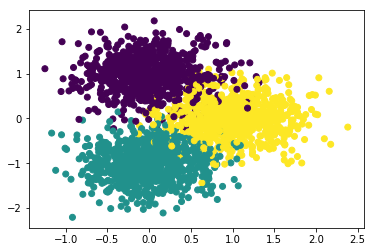

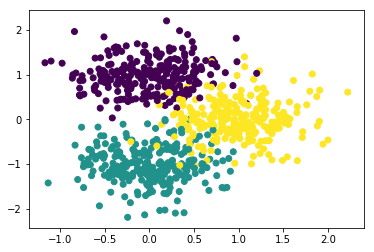

In [92]:
plt.scatter(x_train[:,0],x_train[:,1],c=y_train)
plt.show()
plt.scatter(x_test[:,0],x_test[:,1],c=y_test)
plt.show()


In [193]:
np.savetxt('datasim_X_train.csv',x_train,delimiter=',')
np.savetxt('datasim_Z_train.csv',y_train,fmt='%d') #ground truth
np.savetxt('datasim_X_test.csv',x_test,delimiter=',')
np.savetxt('datasim_Z_test.csv',y_test,fmt='%d') #ground truth

In [2]:
y_train = np.loadtxt("../syntetic/simple/datasim_Z_train.csv",delimiter=',',dtype='int')

### Simmulate groups automatically
---
A big question... **what model should I use?** Pro? simple? adjusted to the task?  
Another big question.. **where measure confusion matrix??** Test or train?

In [3]:
from learning_models import *
from utils import *
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import normalize
from keras.models import clone_model

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

In [4]:
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=1e-2) #relative delta

In [ ]:
from keras.callbacks import EarlyStopping
usualCallback = EarlyStopping(patience=2,monitor='loss',min_delta=5e-2) 

def defaultconv_classifier(X_train,y_train,epochs=25,batch_size=256):
    model = CNN_simple(X_train.shape[1:],y_train.shape[1],32,2,double=False,BN=False,drop=0.25)
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=False)
    return model

def defaultshallow_classifier(X_train,y_train,epochs=1,batch_size=64):
    model = Sequential()
    model.add(Dense(y_train.shape[1],activation='softmax',input_shape=X_train.shape[1:]))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=False)
    return model

def defaultmnist_classifier(X_train,y_train,epochs=1,batch_size=256):
    """Needed noise added with dropout because the easy of the task"""
    it = Input(shape=X_train.shape[1:])
    drop_it = Dropout(0.9)(it)
    modelo_aux = CNN_simple(X_train.shape[1:],y_train.shape[1],8,2,double=False,BN=False,drop=0.5) #very simple
    model = Model(inputs=it,outputs=modelo_aux(drop_it))
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=False)
    return model

def defaultcifar_classifier(X_train,y_train,epochs=15,batch_size=256):
    """ Simple model trained on few epochs, so that it can do mistake"""
    model = CNN_simple(X_train.shape[1:],y_train.shape[1],16,2,double=False,BN=False,drop=0.0) #very simple
    model.compile(loss='categorical_crossentropy',optimizer='rmsprop')
    model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=0,callbacks=[usualCallback])
    return model

def cluster_data(x,M):
    if len(x.shape)>2:
        data_flatten= x.reshape(x.shape[0],np.prod(x.shape[1:]))
    else:
        data_flatten = x
    model = PCA(n_components=16)
    data_compress = model.fit_transform(data_flatten)
    cluster = MiniBatchKMeans(n_clusters=M,batch_size=256)
    cluster.fit(data_compress)
    indexs_m = []
    for m in range(M):
        indexs = np.where(cluster.labels_==m)[0]
        indexs_m.append(indexs)
    return indexs_m

In [ ]:
from keras.callbacks import EarlyStopping
usualCallback = EarlyStopping(patience=3) #(monitor='val_loss', min_delta=0, patience=0)

#first option: train various simple models on partitions of data --Yann 2011
M = 5
#M_sizeN = int(round(x_train.shape[0]/float(M)))
#and previous clustering?
indexs_m = cluster_data(x_train,M)

conf_matrix = [] #The "M" confusion matrices
set_measure = [x_train,y_train] #set to measure confusion matrix
for m in range(M):
    X_aux = x_train[indexs_m[m]]#[m*M_sizeN:(m+1)*M_sizeN]
    Z_aux = y_train[indexs_m[m]] #[m*M_sizeN:(m+1)*M_sizeN]
    if len(Z_aux.shape) < 2 or Z_aux.shape[1] == 1:
        Z_aux_ohv = keras.utils.to_categorical(Z_aux)
    #modelo_aux = defaultshallow_classifier(X_aux,Z_aux_ohv,epochs=15) #o 25 epochs con batch 256
    
    #how to make the task difficult? dropout on input
    #modelo_aux =  defaultmnist_classifier(X_aux,Z_aux_ohv,epochs=1,batch_size=256)
    modelo_aux = defaultcifar_classifier(X_aux,Z_aux_ohv,epochs=100,batch_size=256) 
    
    y_pred_ohv = np.argmax(modelo_aux.predict(set_measure[0]) ,axis=1)

    print("Accuracy: ",accuracy_score(set_measure[1],y_pred_ohv))
    #confusion matrixs on test set or in defect all train
    conf_m = confusion_matrix(y_true=set_measure[1], y_pred=y_pred_ohv)
    conf_m = normalize(conf_m, axis=1, norm='l1')
    conf_matrix.append(conf_m)
conf_matrix = np.asarray(conf_matrix)
conf_matrix

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix[1],label_names)  

In [ ]:
print("This form of simulated has: ",distance_2_centroid(conf_matrix))

### second option
* train over ground truth --Kajino
* Disturb the parameters of the learned model (easier to control)

In [26]:
#model choice

y_train_ohv = keras.utils.to_categorical(y_train)
modelo_true = CNN_simple(x_train.shape[1:],y_train_ohv.shape[1],16,2,double=True,BN=False,drop=0.25) #good performance simple model
#modelo_true = MLP_Keras(x_train.shape[1:],y_train_ohv.shape[1],8,1,BN=False,drop=0.25) #good performance simple model

modelo_true.compile(loss='categorical_crossentropy',optimizer='rmsprop')
modelo_true.fit(x_train,y_train_ohv,batch_size=256,epochs=100,verbose=0,callbacks=[ourCallback]) #until learn enough

weights_true = modelo_true.get_weights()
layer_names = [weight.name for layer in modelo_true.layers for weight in layer.weights]

In [33]:
#corrupts = [0.1,0.3,0.6,0.8] #[0.,0.1,0.2,0.3,0.4] #values of corrupt 
#OJO: con que el modelo tenga batchnormalization, esos pesos no deben ser alterados
#con BN y con test set las desviaciones deben ser pequenas    

#FOR Syntetic data
#M = 3
#corrupts = [0.2,0.8,1.5]

M = 4
corrupts = [0.1,0.2,0.3,0.5] #good values for CIFAR

#corrupts = [0.05,0.15,0.2,0.3] #mask noise
new_weights = [[] for i in range(M) ]
for layer in range(len(weights_true)): #corrupt every layer
    if "batch_normalization" in layer_names[layer]: 
        for m in range(M):
            new_weights[m].append(weights_true[layer]) #does not corrupt BN
        continue #skip those layers
    weights_true_layer = weights_true[layer]
    mean = np.mean(weights_true_layer)
    std = np.std(weights_true_layer)
    #normalize
    normalize_weights = (weights_true_layer-mean)/std
    for m in range(M):
        #corrupt
        devst = corrupts[m]
        gaussian_noise = np.random.normal(loc=0.0, scale=devst, size=normalize_weights.shape)
        normalize_weights_noise = normalize_weights+ gaussian_noise

        #noise_mask = np.random.binomial(n=1, p=1-devst, size=normalize_weights.shape)
        #normalize_weights_noise = normalize_weights* noise_mask

        #un-normalize
        weights_corrupt_layer = normalize_weights_noise*std + mean
        new_weights[m].append(weights_corrupt_layer)
        
conf_matrix = [] #The "M" confusion matrices
set_measure = [x_test,y_test] #set to measure confusion matrix
for m in range(M):
    it = Input(shape=x_train.shape[1:])
    modelo_m = clone_model(modelo_true,input_tensors=it)
    modelo_m.set_weights(new_weights[m])
    
    y_pred_ohv = np.argmax(modelo_m.predict(set_measure[0]) ,axis=1)

    print("Accuracy: ",accuracy_score(set_measure[1],y_pred_ohv))
    conf_m = confusion_matrix(y_true=set_measure[1], y_pred=y_pred_ohv) #confusion matrixs on test set or in defect all train
    conf_m = normalize(conf_m, axis=1, norm='l1')
    conf_matrix.append(conf_m)
conf_matrix = np.asarray(conf_matrix)
print("END")

Accuracy:  0.725
Accuracy:  0.5365
Accuracy:  0.4841
Accuracy:  0.3877
END


In [ ]:
Accuracy:  0.7366
Accuracy:  0.6002
Accuracy:  0.4484
Accuracy:  0.3219

In [26]:
label_names = [0,1,2]

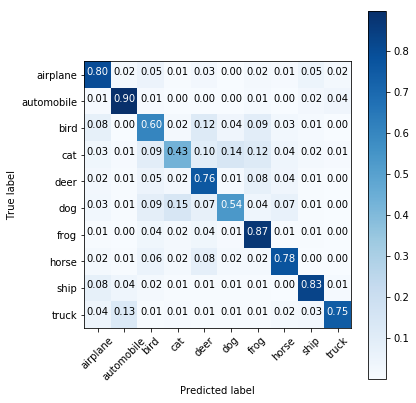

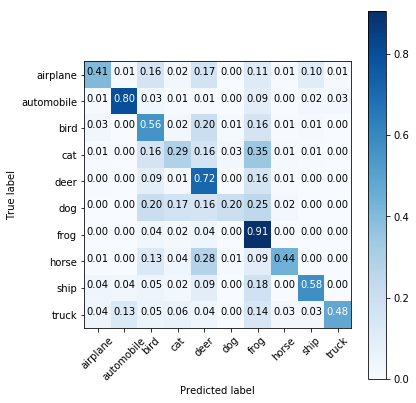

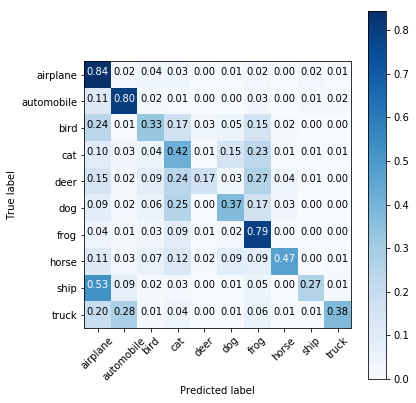

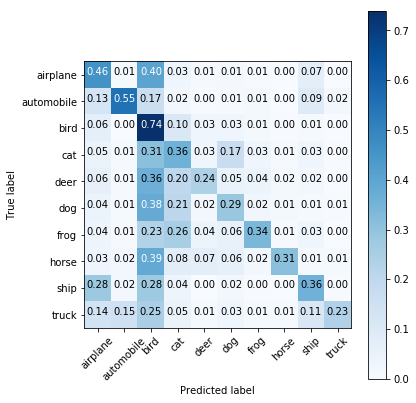

In [34]:
for m in range(conf_matrix.shape[0]):
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(conf_matrix[m],label_names)  #una buena (pero no tan buena) red-- que se equivoque

In [39]:
load_matrix = np.loadtxt('../syntetic/CIFAR/matrix_cifar_normal.csv',delimiter=',')
rows,Kl = load_matrix.shape
conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])

In [38]:
print("This form of simulated has: ",distance_2_centroid(conf_matrix_2))

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix_2,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

print("Accuracy of MV on train: ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

This form of simulated has:  0.277037129735848
Accuracy of MV on train:  0.74758


In [35]:
print("This form of simulated has: ",distance_2_centroid(conf_matrix))

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

print("Accuracy of MV on train: ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

This form of simulated has:  0.18168592211738083
Accuracy of MV on train:  0.7307


In [49]:
from PIL import Image, ImageEnhance
def distort_matrixs(conf_M,scale_value):
    return_value = np.zeros(conf_M.shape)
    for m,conf_m in enumerate(conf_M):
        image = Image.fromarray(np.uint8(cm.gist_earth(conf_m)*255))

        image = ImageEnhance.Brightness(image).enhance(scale_value)
        #image = ImageEnhance.Contrast(image).enhance(scale_value)
        image = image.convert('L')

        returned_image = np.asarray(image)
        returned_image = returned_image/np.expand_dims(np.sum(returned_image,axis=-1),axis=-1)
        return_value[m] = returned_image
    return return_value

#new_conf_matrix = distort_matrixs(conf_matrix,scale_value=5) #noiser

#let experts
new_conf_matrix = distort_matrixs(conf_matrix[1:],scale_value=3)
new_conf_matrix = np.concatenate([np.expand_dims(conf_matrix[0],axis=0),new_conf_matrix],axis=0)
new_conf_matrix.shape

(4, 10, 10)

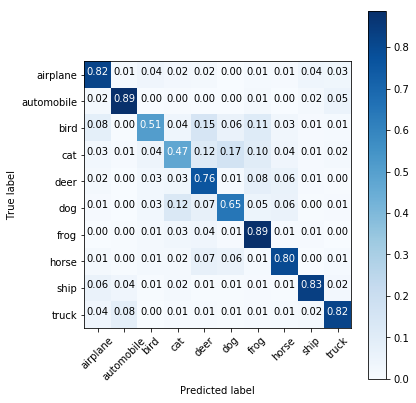

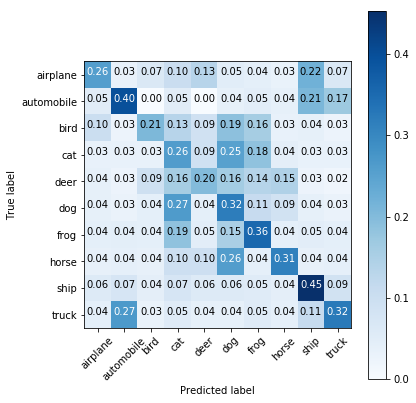

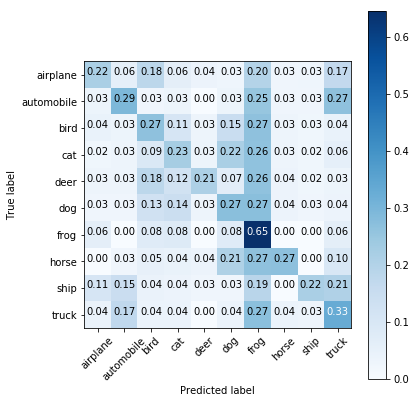

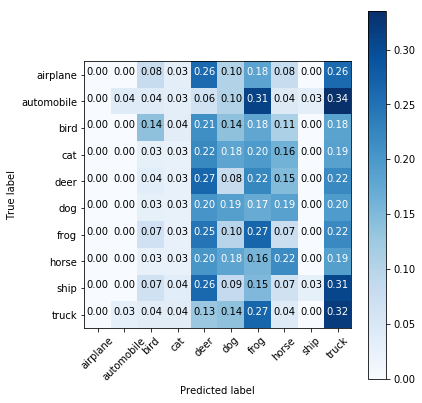

In [43]:
for m in range(conf_matrix.shape[0]):
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(new_conf_matrix[m],label_names)  #una buena (pero no tan buena) red-- que se equivoque

In [48]:
print("This form of simulated has: ",distance_2_centroid(new_conf_matrix))

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=new_conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

print("Accuracy of MV on train: ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

This form of simulated has:  0.2642722937738855
Accuracy of MV on train:  0.65372


#### Group belonging

In [13]:
from representation import *
from generate_data import SinteticData

In [14]:
#grupo1: expertos
#grupo2: anotadores inexpertos
#grupo3: anotadores bastante inexpertos
#grupo4: anotadores casi random

proba_groups = np.asarray([0.05,0.3,0.5,0.15])  #FOR CIFAR
#proba_groups = np.asarray([0.25,0.6,0.15])  #FOR Syntetic

In [88]:
majority_voting(groups.T,repeats=False,probas=True) #hard

array([[0.04, 0.32, 0.48, 0.16]])

In [104]:
np.mean(groups,axis=0) #soft

array([0.05872619, 0.27717857, 0.52023016, 0.14386508])

In [183]:
GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)
print("Accuracy of MV on train: ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

Accuracy of MV on train:  0.8472949389179756


In [184]:
GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False,hard=False)
print("Accuracy of MV on train (soft): ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

/home/fmena/Desktop/Dataset_Tesis/code/generate_data.py:51: RuntimeWarning: invalid value encountered in true_divide
  grupo = grupo/np.sum(grupo) #soft


Accuracy of MV on train (soft):  0.7993019197207679


In [187]:
groups

array([[0.25      , 0.        , 0.75      , 0.        ],
       [0.        , 0.28571429, 0.42857143, 0.28571429],
       [0.        , 0.5       , 0.25      , 0.25      ],
       [0.        , 0.33333333, 0.5       , 0.16666667],
       [0.2       , 0.4       , 0.4       , 0.        ],
       [0.        , 0.        , 0.66666667, 0.33333333],
       [0.        , 0.25      , 0.75      , 0.        ],
       [0.        , 0.25      , 0.75      , 0.        ],
       [0.        , 0.66666667, 0.        , 0.33333333],
       [0.        , 0.33333333, 0.66666667, 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.16666667, 0.16666667, 0.33333333, 0.33333333],
       [0.16666667, 0.33333333, 0.16666667, 0.33333333],
       [0.14285714, 0.57142857, 0.28571429, 0.        ],
       [0.        , 0.28571429, 0.71428571, 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.16666667, 0.        , 0.83333333, 0.        ],
       [0.        , 0.33333333,

In [181]:
from generate_data import SinteticData

GenerateData = SinteticData()
#GenerateData.set_probas(asfile=True,file_matrix='matrix.csv',file_groups='groups.csv')
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)

Tmax = 5000 #opciones: 2000, 5000(*), 10000
T_data = 50 #opciones: 50, 100(*), 250
#Y = (y_train+1)/2
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)
annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ...,  6, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [159]:
print("Accuracy of MV on train: ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

Accuracy of MV on train:  0.81786


In [175]:
print("Accuracy of MV on train2 (5000 T): ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

Accuracy of MV on train2:  0.87464


In [180]:
print("Accuracy of MV on train (2000 T): ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

Accuracy of MV on train (2000 T):  0.87126


In [182]:
print("Accuracy of MV on train (5000 T - 50Real): ",np.mean(majority_voting(annotations,repeats=False,onehot=False) == y_train))

Accuracy of MV on train (5000 T - 50Real):  0.8502


In [177]:
#all good- save it
dataset_info = "cifar"
GenerateData.save_sintetic('annotations_'+dataset_info+'.csv') #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info+'.csv')

In [178]:
GenerateData.save_generation_files(dataset_info)

#### Data Generation
---
Different configuration:
1. Normal ($T = 100, T_d = 10$)
2. Normal but soft clustering
3. Manny annot ($T=2000, T_d = 20$)
4. Manny annot v2 ($T=10000, T_d = 40$)
5. bad MV  with (1) 
6. bad MV with (3) 

In [50]:
dataset_info = "CIFAR_normal"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=False) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=False)
GenerateData.save_generation_files(dataset_info)
del GenerateData
gc.collect()

113361

In [52]:
dataset_info = "CIFAR_manyAnnot_v1"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
#GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_normal.csv',file_groups ='../syntetic/simple/groups_datasim.csv')

Tmax = 2000 
T_data = 25
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=True) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=True)
del GenerateData
gc.collect()

195

In [53]:
dataset_info = "CIFAR_manyAnnot_v2"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
#GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_normal.csv',file_groups ='../syntetic/simple/groups_datasim.csv')

Tmax = 10000 
T_data = 40
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=True) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=True)
del GenerateData
gc.collect()

0

In [54]:
dataset_info = "CIFAR_normal_soft"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=conf_matrix,file_groups =proba_groups)
#GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple_v4/matrix_datasim_normal.csv',file_groups ='../syntetic/simple_v4/groups_datasim_normal.csv')
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False,hard=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=False) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=False)
del GenerateData
gc.collect()

24

In [55]:
dataset_info = "CIFAR_normal_badMV"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=new_conf_matrix,file_groups =proba_groups)
Tmax = 100
T_data = 10 
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False,hard=True)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=False) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=False)
GenerateData.save_generation_files(dataset_info,npy=False)
del GenerateData
gc.collect()

48

In [56]:
dataset_info = "CIFAR_manyAnnot_v1_badMV"

GenerateData = SinteticData()
GenerateData.set_probas(asfile=False,file_matrix=new_conf_matrix,file_groups =proba_groups)
#GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_badMV.csv',file_groups ='../syntetic/simple/groups_datasim.csv')

Tmax = 2000
T_data = 20
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=True) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=True)
del GenerateData
gc.collect()

0

dataset_info = "datasim_manyAnnot_v2_badMV"

GenerateData = SinteticData()
#GenerateData.set_probas(asfile=False,file_matrix=new_conf_matrix,file_groups =proba_groups)
GenerateData.set_probas(asfile=True,file_matrix='../syntetic/simple/matrix_datasim_badMV.csv',file_groups ='../syntetic/simple/groups_datasim.csv')

Tmax = 10000
T_data = 40
annotations, groups = GenerateData.sintetic_annotate_data(y_train,Tmax,T_data,deterministic=False)

GenerateData.save_sintetic('annotations_'+dataset_info,npy=True) #save annotations
GenerateData.save_groups('annotgroups_'+dataset_info,npy=True)
del GenerateData
gc.collect()